# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

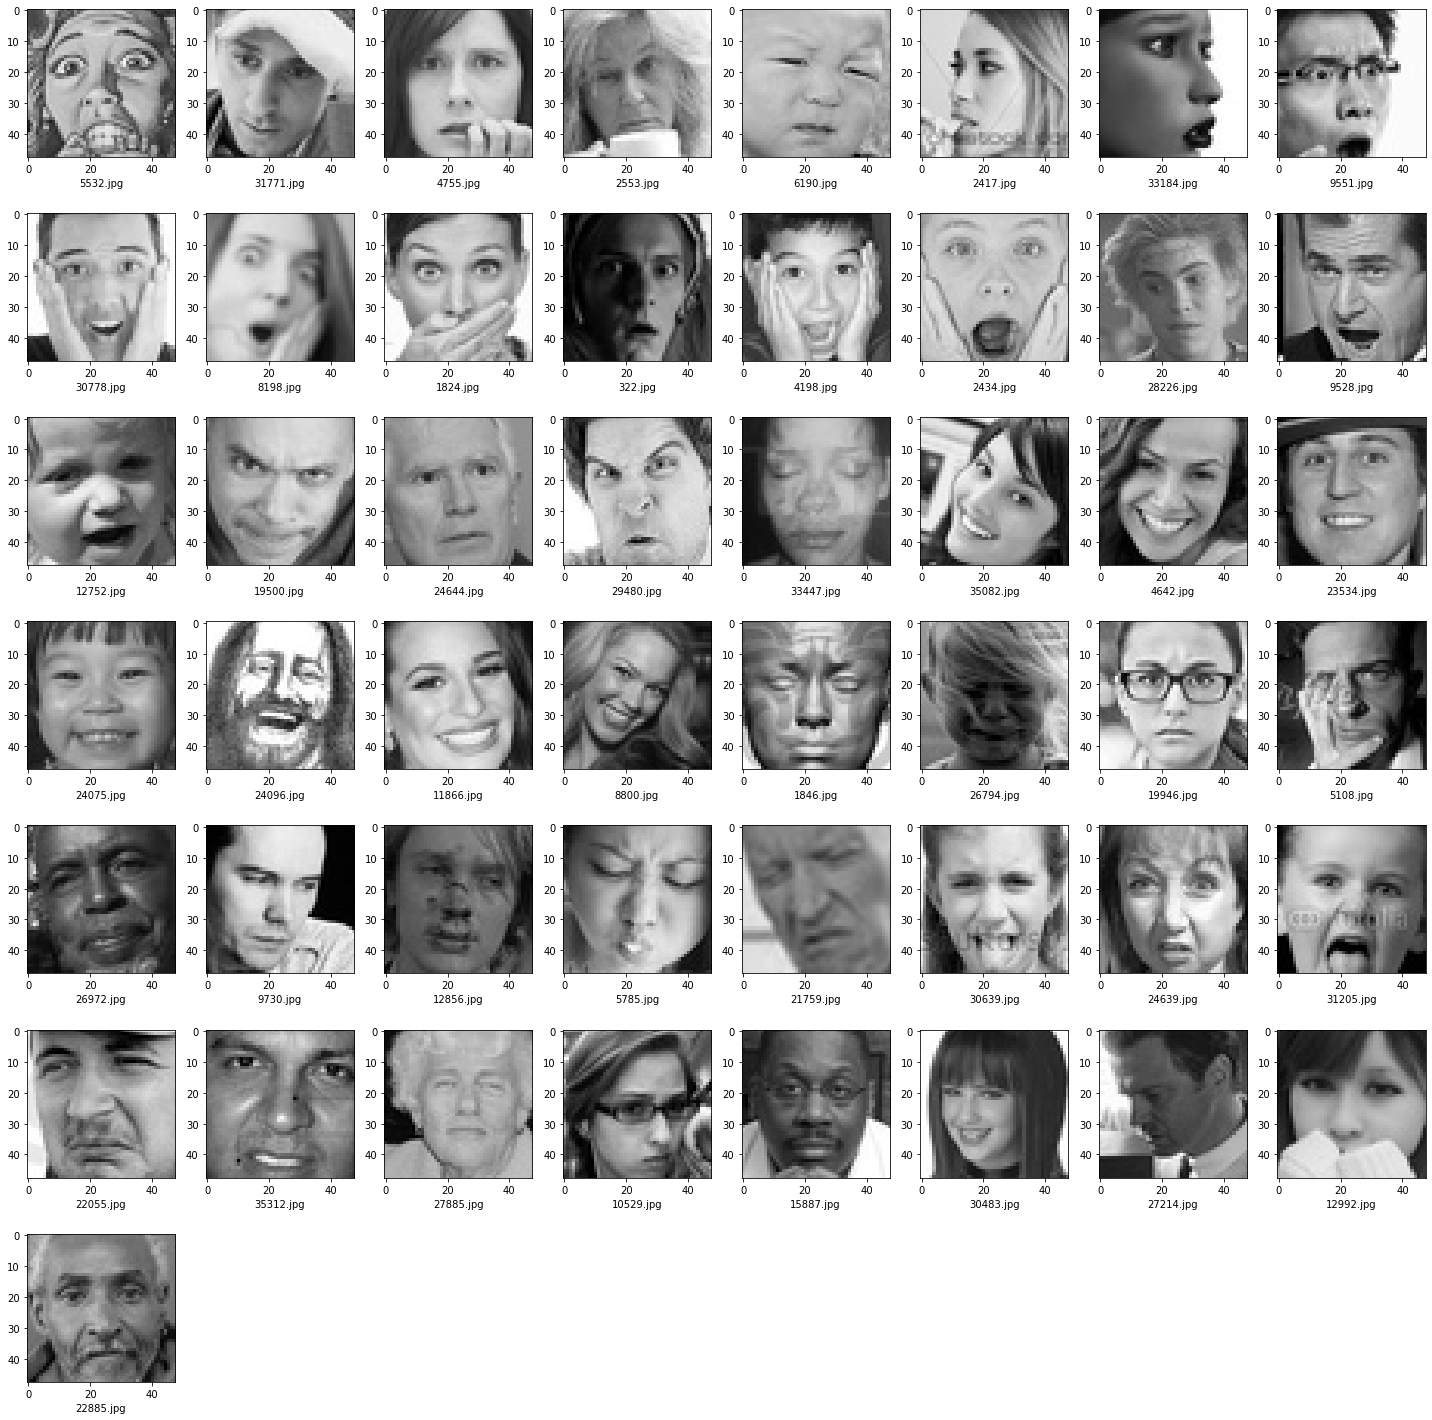

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 25.24 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-wprdc5y6
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-wprdc5y6
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-10, +10)),
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [ ]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform= train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform= valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


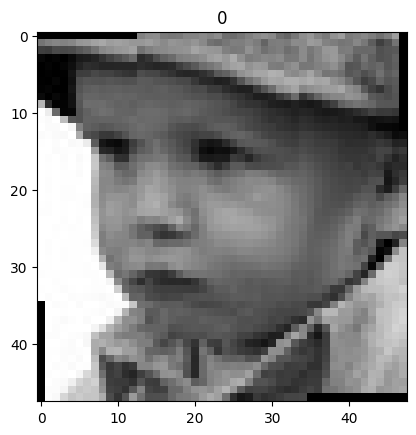

In [ ]:
image , label = trainset[20]
plt.imshow(image.permute(1,2,0)) # (h,w,c)  (c,h,w)
plt.title(label);

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset , batch_size= BATCH_SIZE , shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images, labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

#sinceimages are greyscaled we can keep one channel (rather than the 3 -- rgb)

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [ ]:
import timm
from torch import nn

In [ ]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()

    self.eff_net = timm.create_model('efficientnet_b0' , pretrained = True, num_classes = 7)

  def forward(self, images, labels= None):
   logits = self.eff_net(images)

   if labels != None:
    loss = nn.CrossEntropyLoss()(logits, labels)
    return logits , loss
   return logits



In [ ]:
model = FaceModel()
model.to(DEVICE)
#add ; if you don't wanna see the output of the command

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model, dataloader, optimizer ,current_epo ):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk= tqdm(dataloader, desc= "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)), })

  return total_loss / len(dataloader), total_acc/ len(dataloader)


In [ ]:
def eval_fn(model, dataloader,current_epo ):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk= tqdm(dataloader, desc= "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss+=loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)), })

  return total_loss / len(dataloader), total_acc/ len(dataloader)

# Create Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader , i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss = valid_loss

EPOCH[TRAIN]1/15: 100%|██████████| 221/221 [00:06<00:00, 33.06it/s, loss=1.169680, acc=0.552776]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]2/15: 100%|██████████| 221/221 [00:06<00:00, 33.42it/s, loss=1.139184, acc=0.567612]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]3/15: 100%|██████████| 221/221 [00:07<00:00, 31.08it/s, loss=1.094144, acc=0.588398]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]4/15: 100%|██████████| 221/221 [00:06<00:00, 34.97it/s, loss=1.090234, acc=0.588301]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]5/15: 100%|██████████| 221/221 [00:07<00:00, 30.79it/s, loss=1.054263, acc=0.610838]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]6/15: 100%|██████████| 221/221 [00:06<00:00, 33.24it/s, loss=1.021852, acc=0.623358]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]9/15: 100%|██████████| 221/221 [00:06<00:00, 33.32it/s, loss=0.968215, acc=0.646852]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]15/15: 100%|██████████| 221/221 [00:06<00:00, 33.51it/s, loss=1.046153, acc=0.642980]


# Inference

In [98]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

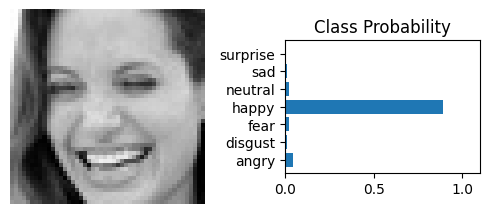

In [143]:
model.to(DEVICE)
image, label = validset[3010]
image = image.unsqueeze(0)
logits = model(image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)
view_classify(image.squeeze(), probs)


In [113]:
from torchvision import transforms
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of the model
    transforms.ToTensor(),          # Convert to a PyTorch Tensor
    # Include any other preprocessing steps used during training (e.g., normalization)
])

# Load the image
image_path = 'test9.jpg'
image = Image.open(image_path).convert('RGB')  # Convert to RGB if it's not

# Apply the transformation
img_tensor = transform(image).unsqueeze(0)  # Add batch dimension


In [114]:
model = FaceModel()
model.load_state_dict(torch.load('best-weights.pt'))
model.eval();

In [115]:
import torch

with torch.no_grad():  # No need to track gradients
    logits = model(img_tensor)  # Get the model's predictions
    probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities


The predicted class is: tensor([5])


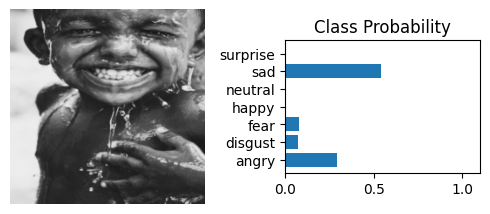

In [116]:
# If you want to see the most likely class
predicted_class = probabilities.argmax(dim=1)
print(f"The predicted class is: {predicted_class}")

# Or use your view_classify function for a full visualization
view_classify(img_tensor.squeeze(), probabilities)  # Remember to remove the batch dimension


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya